In [1]:
import sys; sys.path.append("..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import ELM1D
from wrapper import KS1DModelWrapper
torch.set_grad_enabled(False)

dt = .05
L = 200 
D_all = torch.tensor(np.load('ks1d_inhomogeneous.npy'))

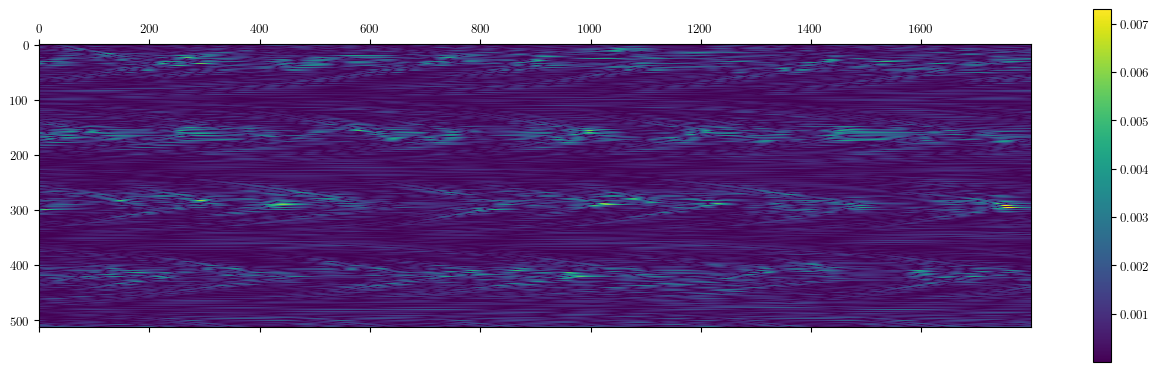

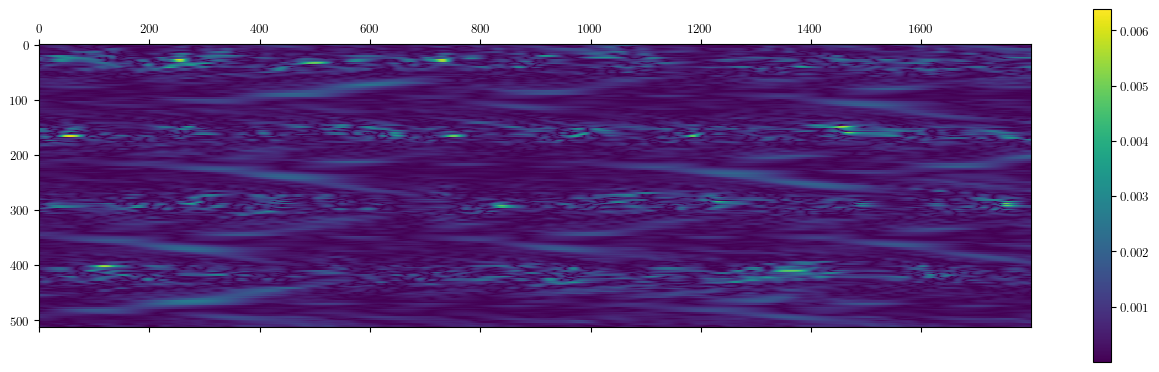

In [8]:
D_train = D_all[:201,...]
D_test = D_all[201:,...]
X_train, Y_train = D_train[:-1,:], D_train[1:,:]
X_test,  Y_test  = D_test[:-1,:],  D_test[1:,:]

model_hom = KS1DModelWrapper(ELM1D(7, 4, 150, 0))
model_inhom = KS1DModelWrapper(ELM1D(7, 4, 150, 3))
model_hom.train(X_train, Y_train, stopping_threshold=1e-4, noise=1e-4)
model_inhom.train(X_train, Y_train, stopping_threshold=1e-4, noise=1e-4)

I = torch.randint(D_test.shape[0]-1,(1000,))

plt.colorbar(plt.matshow((model_inhom(X_test)-Y_test).abs().T.numpy()))
plt.show()
plt.colorbar(plt.matshow((model_hom(X_test)-Y_test).abs().T.numpy()))
plt.show()

In [9]:
M, N = D_test.shape
V_preds = []
V_errors = []

for k, model in enumerate([model_inhom, model_hom]):
    V_pred = torch.empty(M, N, dtype=torch.float64)
    V_pred[0,:] = D_test[0,:]
    for i in range(M-1): V_pred[i+1,:] = model(V_pred[i,None,:]).detach()
    V_preds.append(V_pred)
    V_errors.append((V_pred-D_test).abs())

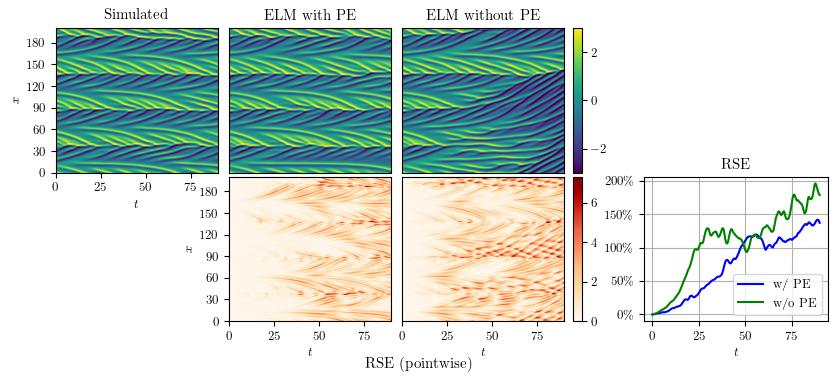

In [10]:
M, N = D_test.shape

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 9,
    'text.latex.preamble': r'\usepackage{amsfonts,bm}'
})

fig = plt.figure(figsize=(10,3.8))
# fig_l, fig_r = fig.subfigures(1,2,width_ratios=[3,1])
(ax_top, ax_btm) = fig.subplots(2,6,width_ratios=[1,1,1,0.05,0.3,1.1], gridspec_kw={"hspace":+0.03, "wspace": .05})

asp = 1/2.5
ext = [0,M*dt,0,L]
norm = D_test.abs().mean(dim=1).numpy()

for k, model in enumerate([model_inhom, model_hom]):
    im1 = ax_top[k+1].imshow(V_preds[k].numpy().T, vmax=3, vmin=-3, aspect=asp, extent=ext)
    im2 = ax_btm[k+1].imshow(V_errors[k].numpy().T, aspect=asp, cmap="OrRd", extent=ext)
    
ax_top[1].set_title("ELM with PE")
ax_top[2].set_title("ELM without PE")
ax_btm[1].set_xlabel("$t$")
ax_btm[2].set_xlabel("$t$")
ax_top[0].set_ylabel("$x$")
ax_btm[1].set_ylabel("$x$")
ax_top[1].set_yticks([])
ax_top[2].set_yticks([])
ax_btm[2].set_yticks([])
ax_top[1].set_xticks([])
ax_top[2].set_xticks([])
fig.colorbar(im1, cax=ax_top[3])
fig.colorbar(im2, cax=ax_btm[3])

ax_top[0].yaxis.set_major_locator(plt.MultipleLocator(30))
ax_top[0].xaxis.set_major_locator(plt.MultipleLocator(25))
ax_btm[1].yaxis.set_major_locator(plt.MultipleLocator(30))

ax_btm[1].text(105, -50, "RSE (pointwise)", ha="center", va="top", rotation="horizontal", fontsize="large")
ax_btm[0].remove()
ax_top[0].set_title("Simulated")
ax_top[0].set_xlabel("$t$")
img = D_test
im0 = ax_top[0].imshow(img.T.numpy(), vmax=3, vmin=-3, aspect=asp, extent=ext)

ax_top[4].remove()
ax_btm[4].remove()

from matplotlib import ticker
ax_btm[5].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,_: f"${100*x:.0f}\%$"))

t = torch.linspace(0,M*dt,M).numpy()
ax_top[5].remove()
ax_btm[5].plot(t,V_errors[0].mean(dim=1).numpy() / norm, color="blue", label="w/ PE")
ax_btm[5].plot(t,V_errors[1].mean(dim=1).numpy() / norm, color="green", label="w/o PE")
ax_btm[5].grid()
ax_btm[5].set_title("RSE")
ax_btm[5].set_xlabel("$t$")
ax_btm[5].legend(loc="lower right")

plt.savefig("plots/ks1d_inhomogeneous.pdf", format="pdf", bbox_inches="tight")
plt.show()


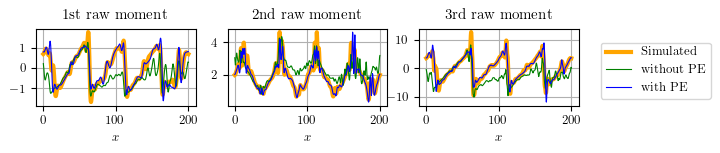

In [11]:
x = torch.linspace(0,L,N)
t = torch.linspace(0,dt*M,M)

fig, ax = plt.subplots(1,3,figsize=(7,1))
ax[0].set_title(f"1st raw moment")
ax[1].set_title(f"2nd raw moment")
ax[2].set_title(f"3rd raw moment")
for k in range(3):
    ax[k].plot(x, D_test.pow(k+1).mean(dim=0),linewidth=3,color="orange",label="Simulated")
    ax[k].plot(x, V_preds[1].pow(k+1).mean(dim=0),linewidth=0.8,color="green",label="without PE")
    ax[k].plot(x, V_preds[0].pow(k+1).mean(dim=0),linewidth=0.8,color="blue",label="with PE")
    ax[k].set_xlabel("$x$")
    ax[k].grid()
ax[2].legend(bbox_to_anchor=(+1.1, 0.9))
# err0 = (V_preds[0]-denormalize(D_test)).pow(2).mean(dim=1)
# err0 = err0/denormalize(D_test).pow(2).mean(dim=1)
# err1 = (V_preds[1]-denormalize(D_test)).pow(2).mean(dim=1)
# err1 = err1/denormalize(D_test).pow(2).mean(dim=1)
# ax[3].plot(t, err1,alpha=0.8,color="green")
# ax[3].plot(t, err0,color="blue")
# ax[3].set_title("Relative MSE over time")
# ax[3].set_xlabel("$t$")
# ax[3].grid()
plt.savefig("plots/statistics.pdf", format="pdf", bbox_inches="tight")
plt.show()